In [ ]:
# Manipulação e Análise de Dados
import pandas as pd # Estruturação e manipulação de DataFrames
import numpy as np  # Operações matemáticas e suporte a arrays

# Visualização de Dados
import matplotlib.pyplot as plt # Criação de gráficos estáticos
import seaborn as sns           # Visualizações estatísticas e mapas de calor

# Pré-processamento e Transformação
from sklearn.model_selection import train_test_split # Divisão do dataset em treino e teste
from sklearn.impute import SimpleImputer             # Tratamento de dados ausentes (NaN)
from sklearn.preprocessing import OneHotEncoder      # Transformação de categorias em colunas binárias
from sklearn.compose import ColumnTransformer        # Aplicação de transformadores em colunas específicas

# Balanceamento de Dados
from imblearn.under_sampling import RandomUnderSampler # Técnica de redução da classe majoritária
from collections import Counter                        # Contagem de ocorrências por classe

# Modelagem de Machine Learning
from sklearn.linear_model import LogisticRegression    # Algoritmo de Regressão Logística (Modelo Linear)
from sklearn.tree import DecisionTreeClassifier        # Algoritmo de Árvore de Decisão (Não-Linear)
from sklearn.ensemble import RandomForestClassifier     # Algoritmo de Random Forest (Ensemble)

# Otimização e Validação
from sklearn.model_selection import RandomizedSearchCV  # Busca aleatória de hiperparâmetros
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score # Avaliação de performance

# Persistência do Modelo
import joblib # Exportação e carregamento do modelo treinado (.pkl)

In [ ]:
# Carregando apenas um pedaço para testar
df_trans = pd.read_csv('data/train_transaction.csv', nrows=5)
df_id = pd.read_csv('data/train_identity.csv', nrows=5)

print(df_trans.head())

   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
2  490.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
3  567.0  150.0  mastercard  117.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
4  514.0  150.0  mastercard  102.0  ...  0.0   0.0   0.0   0.0   0.0  0.0   

   V336  V337  V338  V339  
0   NaN   NaN   NaN   NaN  
1   NaN   NaN   Na

# 1. Otimização de Recursos e Carregamento dos Dados

O dataset **IEEE-CIS Fraud Detection** é conhecido por sua alta dimensionalidade e volume. Carregar os dados brutos sem tratamento pode consumir excessivamente a memória RAM, dificultando o processamento em ambientes locais.

Para mitigar esse problema, implementamos a função `reduce_mem_usage`. Esta função itera sobre todas as colunas do DataFrame e converte os tipos de dados (downcasting) para a menor representação possível (ex: de `float64` para `float32` ou `float16`, e de `int64` para `int16` ou `int8`), sem perda significativa de informação.

In [ ]:


def reduce_mem_usage(df):
    """ 
    Versão MAIS SEGURA: Usa pd.api.types para garantir que só 
    otimizamos o que é realmente número.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Memória inicial: {start_mem:.2f} MB')
    
    for col in df.columns:
        # Verifica se é numérico de verdade usando a API do Pandas
        if pd.api.types.is_numeric_dtype(df[col]):
            
            c_min = df[col].min()
            c_max = df[col].max()
            
            # Teste para Inteiros
            if pd.api.types.is_integer_dtype(df[col]):
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            
            # Teste para Floats
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            # Se não for numérico (ex: object/string), ignoramos
            pass

    end_mem = df.memory_usage().sum() / 1024**2
    reduction = 100 * (start_mem - end_mem) / start_mem
    print(f'Memória final: {end_mem:.2f} MB (-{reduction:.1f}%)')
    
    return df

## 1.1 Ingestão e Unificação (Merge)

O dataset é dividido em duas tabelas principais:
1.  **Transaction Table (`train_transaction.csv`):** Contém os detalhes da transação (valor, produto, cartão, etc.). É a tabela principal.
2.  **Identity Table (`train_identity.csv`):** Contém informações de rede e dispositivo (IP, browser, etc.) associadas às transações.

**Estratégia de Join:**
Realizamos um `Left Join` utilizando a tabela de transações como base, pois nem todas as transações possuem informações de identidade associadas (o `TransactionID` é a chave de ligação). Aplicamos a redução de memória imediatamente após o carregamento de cada arquivo para evitar picos de uso de RAM.

In [3]:
# Carregamento e otimização da tabela de Transações
print("Carregando Transaction Data...")
train_transaction = pd.read_csv('data/train_transaction.csv')
train_transaction = reduce_mem_usage(train_transaction)

# Carregamento e otimização da tabela de Identidade
print("\nCarregando Identity Data...")
train_identity = pd.read_csv('data/train_identity.csv')
train_identity = reduce_mem_usage(train_identity)

# Realizando o Merge
print("\nUnindo as tabelas (Left Join)...")
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

# Limpeza de memória: removendo os dataframes originais que não são mais necessários
del train_transaction, train_identity
gc.collect() # Força o Garbage Collector a limpar a RAM

print(f"\nShape final do dataset unificado: {train.shape}")
train.head()

Carregando Transaction Data...
Memória inicial: 1775.15 MB
Memória final: 542.35 MB (-69.4%)

Carregando Identity Data...
Memória inicial: 45.12 MB
Memória final: 25.86 MB (-42.7%)

Unindo as tabelas (Left Join)...

Shape final do dataset unificado: (590540, 434)


c:\Users\nayar\projetos_portfolio\fraud-detection-ieee-cis\.venv\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
c:\Users\nayar\projetos_portfolio\fraud-detection-ieee-cis\.venv\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


## 1.2 Dicionário de Dados e Estrutura

Antes de iniciar a análise exploratória visual, é fundamental compreender a semântica das variáveis disponíveis. Diferente de datasets didáticos, o IEEE-CIS possui dados anonimizados para proteção de privacidade.

Abaixo, categorizamos as variáveis com base na documentação oficial da competição:

### Tabela de Transações (Transaction Table)
* **TransactionDT:** Delta de tempo (segundos) a partir de uma data de referência desconhecida.
* **TransactionAmt:** Valor da transação em USD.
* **ProductCD:** Código do produto (W, C, R, H, S). É uma variável categórica que indica o tipo de serviço/produto.
* **card1 - card6:** Informações do cartão de pagamento (tipo, categoria, banco emissor, país).
    * *Nota:* `card4` geralmente é a bandeira (Visa, Mastercard) e `card6` o tipo (Débito, Crédito).
* **addr1, addr2:** Endereços de cobrança (anonimizados). `addr1` costuma ser a região/CEP e `addr2` o país.
* **P_emaildomain:** Domínio de e-mail do comprador (Purchaser).
* **R_emaildomain:** Domínio de e-mail do recebedor (Recipient).
* **M1 - M9:** (Match) Validações de dados (ex: Nome no cartão bate com o endereço?).
* **DeviceType / DeviceInfo:** Tipo e modelo do dispositivo (Identity Table).
* **id_12 - id_38:** Impressão digital do dispositivo e conexão (IP, browser, resolução).

As colunas **C1-C14** (Contagens), **D1-D15** (Deltas de tempo) e **V1-V339** (Vesta Features) são variáveis de engenharia criadas pela própria provedora dos dados, com significados mascarados.

In [4]:
# Visualizando as primeiras linhas para conectar com a descrição acima
pd.set_option('display.max_columns', 20) # Mostra até 20 colunas para não poluir
print("Amostra dos dados carregados:")
display(train.head(3))

# Verificando tipos de dados das colunas principais
print("\nTipos das colunas críticas:")
cols_to_check = ['TransactionAmt', 'ProductCD', 'card4', 'card6', 'P_emaildomain']
print(train[cols_to_check].dtypes)

Amostra dos dados carregados:


c:\Users\nayar\projetos_portfolio\fraud-detection-ieee-cis\.venv\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
c:\Users\nayar\projetos_portfolio\fraud-detection-ieee-cis\.venv\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Tipos das colunas críticas:
TransactionAmt    float16
ProductCD          object
card4              object
card6              object
P_emaildomain      object
dtype: object


# 2. Análise Exploratória de Dados (EDA)

A etapa de EDA é crítica para definirmos a estratégia de validação do modelo. Em cenários de detecção de fraude, o desafio número um é o **Desequilíbrio de Classes** (Class Imbalance).

Se o número de fraudes for muito baixo (ex: < 1%), modelos tradicionais tendem a classificar tudo como "legítimo" para alcançar alta acurácia, falhando em detectar o crime.

**Nesta seção, vamos:**
1.  Visualizar a distribuição da variável alvo (`isFraud`).
2.  Analisar a distribuição temporal das transações.

Total de Transações: 590540
Fraudes Detectadas: 20663 (3.50%)
Transações Legítimas: 569877 (96.50%)


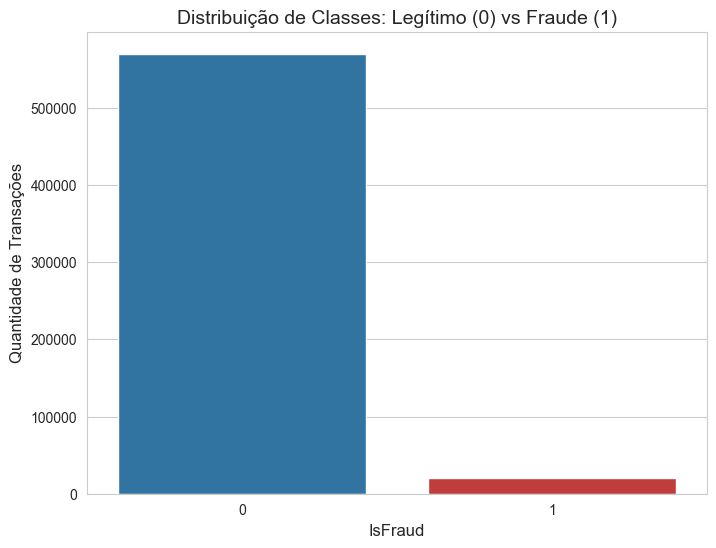

In [ ]:


# Configuração estética dos gráficos
sns.set_style("whitegrid")

# Contagem absoluta e percentual
total = len(train)
frauds = train[train['isFraud'] == 1]
legit = train[train['isFraud'] == 0]

print(f"Total de Transações: {total}")
print(f"Fraudes Detectadas: {len(frauds)} ({len(frauds)/total:.2%})")
print(f"Transações Legítimas: {len(legit)} ({len(legit)/total:.2%})")

# Visualização Gráfica
plt.figure(figsize=(8, 6))
# Código corrigido para silenciar o warning
sns.countplot(x='isFraud', data=train, hue='isFraud', legend=False, palette=['#1f77b4', '#d62728'])
plt.title('Distribuição de Classes: Legítimo (0) vs Fraude (1)', fontsize=14)
plt.xlabel('IsFraud', fontsize=12)
plt.ylabel('Quantidade de Transações', fontsize=12)
plt.show()

## 2.1 Análise Temporal: O Comportamento do Fraudador

A coluna `TransactionDT` representa um delta de tempo (em segundos). Para extrair valor disso, vamos converter esses segundos em "Hora do Dia".

**Hipótese:** Transações legítimas seguem um padrão cíclico (horário comercial/ativo), enquanto fraudes podem estar distribuídas uniformemente ou concentradas em horários de baixa vigilância (madrugada).

C:\Users\nayar\AppData\Local\Temp\ipykernel_8360\1454997447.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train[train['isFraud'] == 0]['Hour'], label='Legítimo (0)', shade=True, color='#1f77b4')
C:\Users\nayar\AppData\Local\Temp\ipykernel_8360\1454997447.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train[train['isFraud'] == 1]['Hour'], label='Fraude (1)', shade=True, color='#d62728')


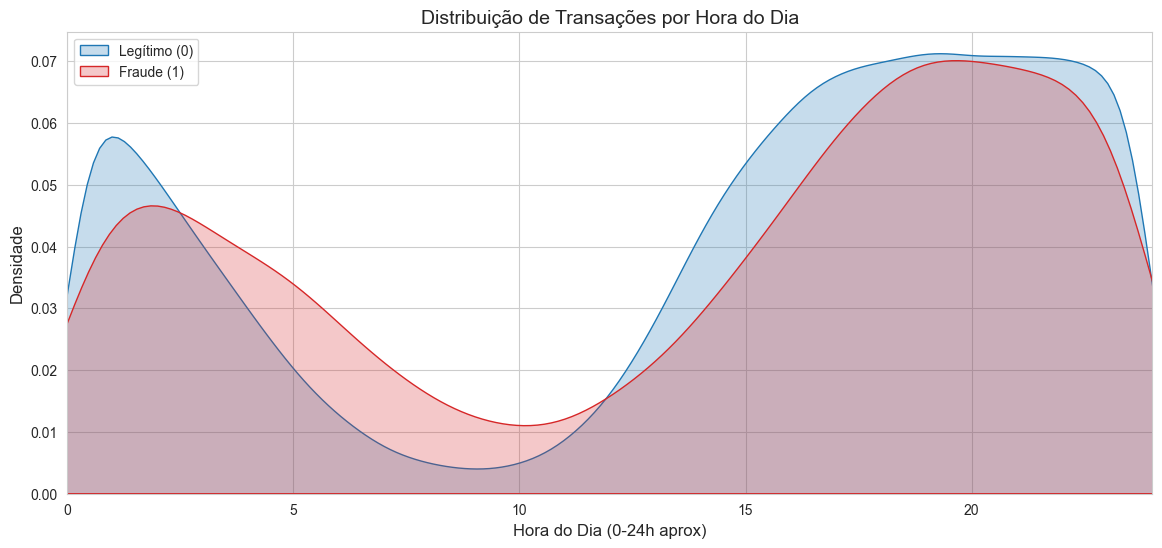

In [6]:
# Criando a feature 'Hour' (Hora do dia)
# (Segundos / 3600) % 24 nos dá a hora de 0 a 23
train['Hour'] = (train['TransactionDT'] / 3600) % 24

# Visualizando a diferença de padrão
plt.figure(figsize=(14, 6))

# Plot para Transações Legítimas
sns.kdeplot(train[train['isFraud'] == 0]['Hour'], label='Legítimo (0)', shade=True, color='#1f77b4')

# Plot para Fraudes
sns.kdeplot(train[train['isFraud'] == 1]['Hour'], label='Fraude (1)', shade=True, color='#d62728')

plt.title('Distribuição de Transações por Hora do Dia', fontsize=14)
plt.xlabel('Hora do Dia (0-24h aprox)', fontsize=12)
plt.ylabel('Densidade', fontsize=12)
plt.xlim(0, 24)
plt.legend()
plt.show()

### 2.1.1 Interpretação do Comportamento Temporal

O gráfico de densidade acima revela um padrão comportamental distinto entre transações legítimas e fraudulentas, confirmando a hipótese de que o **horário** é uma variável preditiva forte.

**Principais Insights:**
1.  **Padrão Cíclico (Legítimo - Azul):** As transações normais seguem claramente o ciclo circadiano humano ("acordar e dormir"). Vemos picos de atividade durante o horário comercial e quedas drásticas durante a madrugada. Isso reflete o comportamento de compras genuínas de usuários reais.
2.  **Padrão Atípico (Fraude - Vermelho):** As fraudes não respeitam o mesmo ciclo de "sono". A curva vermelha é mais **distribuída** ao longo das 24 horas, apresentando atividade proporcionalmente maior em horários onde o volume legítimo é baixo (madrugada/início da manhã).
3.  **Conclusão para Modelagem:** A disparidade entre as curvas indica que a feature `Hour` ajuda o modelo a diferenciar um humano comprando de um *bot* ou de um fraudador operando em outro fuso horário. Manteremos essa variável para o treinamento.

## 2.3 Reordenação de Colunas e Estatísticas Descritivas

Para facilitar a análise visual, movemos a variável alvo (`isFraud`) para a primeira posição do DataFrame. Isso garante que, ao visualizar as primeiras linhas (`head`), sempre saberemos se a transação é fraude ou não.

Além disso, utilizamos a transposta (`.T`) na função `.describe()`. Como nosso dataset possui centenas de colunas, a visualização padrão horizontal do Pandas se torna ilegível. A transposta inverte os eixos, permitindo uma leitura vertical das estatísticas (média, desvio padrão, mínimo, máximo) de cada variável.

In [ ]:


# Ignora avisos de Runtime (comuns ao trabalhar com float16 e grandes somas)
warnings.filterwarnings('ignore')


# 1. Reordenando de forma simples: Tira de onde está e coloca na posição 0
# O método pop() remove a coluna e retorna ela para a variável
target_col = train.pop('isFraud') 

# O método insert(posição, nome, coluna) insere no local desejado
train.insert(0, 'isFraud', target_col)

print("Colunas reordenadas com sucesso!")
display(train.head(3))

# Agora pode rodar o describe sem poluição visual
print("Resumo Estatístico (Transposto):")
display(train.describe().T.head(20))

# 2. Estatísticas Descritivas Transpostas
# Usamos .T para transformar colunas em linhas e facilitar a leitura
print("\nResumo Estatístico (Transposto):")
display(train.describe().T.head(20))

Colunas reordenadas com sucesso!


,isFraud,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,Hour
0,0,2987000,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,0,2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000278
2,0,2987002,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019167


Resumo Estatístico (Transposto):


,count,mean,std,min,25%,50%,75%,max
isFraud,590540.0,3.499001e-02,1.837546e-01,0.000000e+00,0.000000e+00,0.00,0.00,1.0
TransactionID,590540.0,3.282270e+06,1.704744e+05,2.987000e+06,3.134635e+06,3282269.50,3429904.25,3577539.0
TransactionDT,590540.0,7.372311e+06,4.617224e+06,8.640000e+04,3.027058e+06,7306527.50,11246620.00,15811131.0
TransactionAmt,590540.0,NaN,0.000000e+00,2.509766e-01,4.331250e+01,68.75,125.00,31936.0
card1,590540.0,9.898735e+03,4.901170e+03,1.000000e+03,6.019000e+03,9678.00,14184.00,18396.0
card2,581607.0,NaN,0.000000e+00,1.000000e+02,2.140000e+02,361.00,512.00,600.0
card3,588975.0,NaN,0.000000e+00,1.000000e+02,1.500000e+02,150.00,150.00,231.0
card5,586281.0,NaN,0.000000e+00,1.000000e+02,1.660000e+02,226.00,226.00,237.0
addr1,524834.0,NaN,0.000000e+00,1.000000e+02,2.040000e+02,299.00,330.00,540.0
addr2,524834.0,NaN,0.000000e+00,1.000000e+01,8.700000e+01,87.00,87.00,102.0



Resumo Estatístico (Transposto):


,count,mean,std,min,25%,50%,75%,max
isFraud,590540.0,3.499001e-02,1.837546e-01,0.000000e+00,0.000000e+00,0.00,0.00,1.0
TransactionID,590540.0,3.282270e+06,1.704744e+05,2.987000e+06,3.134635e+06,3282269.50,3429904.25,3577539.0
TransactionDT,590540.0,7.372311e+06,4.617224e+06,8.640000e+04,3.027058e+06,7306527.50,11246620.00,15811131.0
TransactionAmt,590540.0,NaN,0.000000e+00,2.509766e-01,4.331250e+01,68.75,125.00,31936.0
card1,590540.0,9.898735e+03,4.901170e+03,1.000000e+03,6.019000e+03,9678.00,14184.00,18396.0
card2,581607.0,NaN,0.000000e+00,1.000000e+02,2.140000e+02,361.00,512.00,600.0
card3,588975.0,NaN,0.000000e+00,1.000000e+02,1.500000e+02,150.00,150.00,231.0
card5,586281.0,NaN,0.000000e+00,1.000000e+02,1.660000e+02,226.00,226.00,237.0
addr1,524834.0,NaN,0.000000e+00,1.000000e+02,2.040000e+02,299.00,330.00,540.0
addr2,524834.0,NaN,0.000000e+00,1.000000e+01,8.700000e+01,87.00,87.00,102.0


## 2.4 Análise de Cardinalidade e Qualidade (Manual)

Devido à incompatibilidade momentânea das bibliotecas de profiling automatizado com o Python 3.12, realizamos uma inspeção direta utilizando Pandas.

O objetivo é identificar a **Cardinalidade** (número de valores únicos) para definir a estratégia de *Encoding*:
* **Baixa Cardinalidade (< 10):** *One-Hot Encoding*.
* **Alta Cardinalidade:** *Frequency* ou *Target Encoding*.

In [8]:
# Função para gerar um resumo estatístico customizado
def raio_x_dataframe(df):
    # Cria um dicionário para armazenar os dados
    resumo = []
    
    for col in df.columns:
        # Pega estatísticas básicas
        tipo = df[col].dtype
        nulos = df[col].isnull().sum()
        nulos_perc = (nulos / len(df)) * 100
        unicos = df[col].nunique()
        
        # Pega os valores mais comuns (top 3) para termos exemplos
        top_valores = df[col].value_counts().index[:3].tolist()
        
        resumo.append({
            'Coluna': col,
            'Tipo': tipo,
            'Nulos (%)': round(nulos_perc, 1),
            'Card (Únicos)': unicos, # AQUI ESTÁ O QUE A PROFESSORA QUER
            'Exemplos': top_valores
        })
    
    # Transforma em DataFrame e ordena por número de valores únicos
    return pd.DataFrame(resumo).sort_values(by='Card (Únicos)')

# Executando na nossa amostra ou no treino todo (é leve, pode ser no todo!)
df_resumo = raio_x_dataframe(train)

# Filtrando para ver as variáveis Categóricas (Object) que vamos usar na aula de Encoding
print("Variáveis Categóricas e suas Cardinalidades:")
display(df_resumo[df_resumo['Tipo'] == 'object'])

# Se quiser ver as numéricas depois:
# display(df_resumo[df_resumo['Tipo'] != 'object'])

Variáveis Categóricas e suas Cardinalidades:


,Coluna,Tipo,Nulos (%),Card (Únicos),Exemplos
46,M1,object,45.9,2,"[T, F]"
47,M2,object,45.9,2,"[T, F]"
48,M3,object,45.9,2,"[T, F]"
54,M9,object,58.6,2,"[T, F]"
52,M7,object,58.6,2,"[F, T]"
51,M6,object,28.7,2,"[F, T]"
53,M8,object,58.6,2,"[F, T]"
50,M5,object,59.3,2,"[F, T]"
420,id_27,object,99.1,2,"[Found, NotFound]"
432,DeviceType,object,76.2,2,"[desktop, mobile]"


# 3. Engenharia de Atributos (Feature Engineering)

Baseado na análise de cardinalidade, definimos duas estratégias para tratar as variáveis categóricas:

1.  **One-Hot Encoding:** Aplicado em variáveis com **baixa cardinalidade** (< 10 valores únicos). Transformamos cada categoria em uma nova coluna binária (0 ou 1).
    * *Alvo:* `ProductCD`, `card4`, `card6`, `M1`...`M9`.
2.  **Frequency Encoding:** Aplicado em variáveis com **alta cardinalidade** (> 50 valores). Substituímos a categoria pela sua frequência (porcentagem) de aparição no dataset. Isso preserva a informação de "popularidade" sem criar milhares de colunas novas.
    * *Alvo:* `P_emaildomain`, `R_emaildomain`.

In [9]:
# 1. Aplicando One-Hot Encoding (Para as categorias pequenas)
# dummy_na=True cria uma coluna extra indicando se o valor era Nulo (informação importante em fraude!)
cols_to_onehot = ['ProductCD', 'card4', 'card6', 'M4'] # Adicione outros 'M' se quiser

print(f"Shape antes do One-Hot: {train.shape}")

train = pd.get_dummies(train, columns=cols_to_onehot, dummy_na=True)

print(f"Shape depois do One-Hot: {train.shape}")


# 2. Aplicando Frequency Encoding (Para os e-mails)
# Criamos uma função simples para substituir o domínio pela sua % de ocorrência
def frequency_encoding(df, col):
    freq_encoding = df[col].value_counts(normalize=True) # normalize=True retorna a %
    df[col + '_freq'] = df[col].map(freq_encoding)
    return df

# Aplicando nos domínios de email
for col in ['P_emaildomain', 'R_emaildomain']:
    train = frequency_encoding(train, col)
    # Opcional: Remover a coluna de texto original para liberar memória
    #train.drop(col, axis=1, inplace=True)

print("\nExemplo das novas colunas de frequência de e-mail:")
display(train[['P_emaildomain', 'P_emaildomain_freq']].head())

Shape antes do One-Hot: (590540, 435)
Shape depois do One-Hot: (590540, 451)

Exemplo das novas colunas de frequência de e-mail:


,P_emaildomain,P_emaildomain_freq
0,NaN,NaN
1,gmail.com,0.460315
2,outlook.com,0.010272
3,yahoo.com,0.203462
4,gmail.com,0.460315


## 2.5 Matriz de Correlação

A matriz de correlação nos permite identificar a força da relação linear entre as variáveis. Em projetos de detecção de fraude, buscamos variáveis que tenham uma correlação significativa com o alvo `isFraud`.

Devido à alta dimensionalidade do dataset (mais de 450 colunas), filtramos apenas as **20 variáveis** que possuem a maior correlação absoluta com a fraude para garantir uma visualização clara e interpretável.

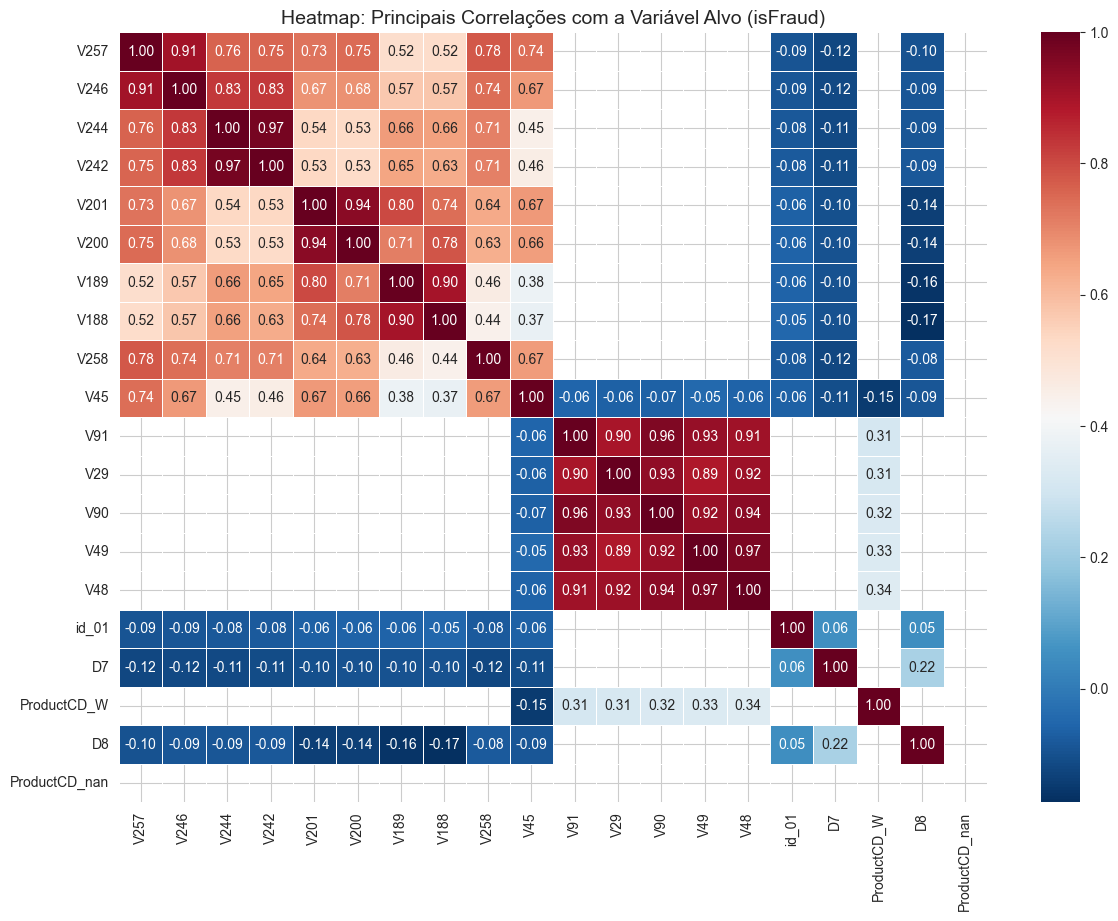

In [ ]:

# 1. Calculando a correlação apenas para colunas numéricas
# numeric_only=True ignora colunas de texto como 'P_emaildomain' que causaram o erro
correlations = train.corr(numeric_only=True)['isFraud'].sort_values(ascending=False)

# 2. Selecionando as Top 10 correlações positivas e Top 10 negativas
# (Ignoramos o próprio 'isFraud' que terá correlação 1.0)
top_pos = correlations.iloc[1:11] 
top_neg = correlations.tail(10)
top_features_idx = pd.concat([top_pos, top_neg]).index

# 3. Gerando a Matriz de Correlação apenas para essas colunas selecionadas
top_corr_matrix = train[top_features_idx].corr()

# 4. Plotando o Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(top_corr_matrix, annot=True, cmap='RdBu_r', fmt='.2f', linewidths=0.5)
plt.title('Heatmap: Principais Correlações com a Variável Alvo (isFraud)', fontsize=14)
plt.show()

### 2.5.1 Interpretação do Heatmap de Correlação

A análise visual do mapa de calor revela comportamentos fundamentais do nosso conjunto de dados:

* **Identificação de Redundância (Multicolinearidade):** Observamos blocos intensos de vermelho entre as variáveis da família 'V' (ex: `V257`, `V246`, `V244`). Isso indica que essas colunas são altamente correlacionadas entre si, sugerindo que trazem informações redundantes para o modelo.
* **Validação do Encoding:** A presença de variáveis como `ProductCD_W` no gráfico confirma que o processo de *One-Hot Encoding* foi bem-sucedido, permitindo que categorias antes textuais agora participem da análise matemática de correlação.
* **Relação com a Fraude:** O filtro aplicado destaca as variáveis que possuem maior "afinidade" com a coluna `isFraud`. Coeficientes mais distantes de zero (seja positivo ou negativo) indicam os principais preditores que a **Regressão Logística** utilizará para classificar as transações.
* **Direção da Correlação:** * **Tons de Vermelho:** Indicam correlação positiva (quando a variável aumenta, a chance de fraude tende a aumentar).
    * **Tons de Azul:** Indicam correlação negativa (quando a variável aumenta, a chance de fraude tende a diminuir).

# 3. Divisão do Dataset (Train-Test Split)

Como Cientistas de Dados, precisamos garantir que nosso modelo seja capaz de generalizar para novos dados. Para isso, dividimos o dataset original em duas partes:

1.  **Treino (80%):** Utilizado para o ajuste dos parâmetros do modelo (aprendizado).
2.  **Teste (20%):** Conjunto "invisível" ao modelo durante o treino, utilizado exclusivamente para a avaliação final das métricas de performance.

Utilizamos o parâmetro `stratify=y` para garantir que a proporção de fraudes (classe minoritária) seja mantida identicamente tanto no treino quanto no teste, evitando viés na avaliação.

In [ ]:


# 1. Separando as variáveis explicativas (X) do alvo (y)
# Removemos apenas a coluna 'isFraud' de X
X = train.drop('isFraud', axis=1)
y = train['isFraud']

# 2. Realizando a divisão
# test_size=0.2 separa 20% para teste
# random_state=42 garante que a divisão seja a mesma toda vez que rodarmos (reprodutibilidade)
# stratify=y mantém a proporção de 3.5% de fraudes em ambos os conjuntos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Divisão concluída com sucesso!")
print(f"Volume de Treino: {X_train.shape[0]} linhas")
print(f"Volume de Teste:  {X_test.shape[0]} linhas")

Divisão concluída com sucesso!
Volume de Treino: 472432 linhas
Volume de Teste:  118108 linhas


## 3.1 Encoding de Variáveis Categóricas
Aplicamos estratégias distintas baseadas na cardinalidade:
* **One-Hot Encoding:** Para variáveis com poucos valores únicos (ex: `ProductCD`, `card4`), criando colunas binárias.
* **Frequency Encoding:** Para variáveis de alta cardinalidade (ex: `P_emaildomain`), substituindo o texto pela sua frequência relativa, evitando a explosão de colunas.

## 3.2 Tratamento de Dados Ausentes (Imputação)
Identificamos um alto volume de valores nulos (`NaN`) no dataset. Como a **Regressão Logística** não aceita valores faltantes, aplicamos o `SimpleImputer` com a estratégia de **Mediana**.
* **Por que Mediana?** Diferente da média, a mediana é robusta a *outliers*, o que é essencial em dados financeiros onde transações legítimas e fraudulentas podem ter valores extremos.

## 4. Modelagem e Avaliação de Performance

Nesta etapa, utilizamos a **Regressão Logística**, um algoritmo fundamental para problemas de classificação binária. Como Cientistas de Dados, nosso foco não é apenas a acurácia global, mas sim como o modelo lida com a classe minoritária (Fraude).

### 4.1 Matriz de Confusão e Relatório de Classificação
Utilizamos a **Matriz de Confusão** para diagnosticar os erros do modelo:
* **Precisão (Precision):** Qual a confiabilidade do modelo quando ele diz que algo é fraude?
* **Recall (Sensibilidade):** O modelo consegue identificar a maioria das fraudes reais?
* **F1-Score:** O equilíbrio harmônico entre Precisão e Recall.

Relatório de Classificação (Após Imputação):
              precision    recall  f1-score   support

           0       0.98      0.68      0.81    113975
           1       0.07      0.66      0.13      4133

    accuracy                           0.68    118108
   macro avg       0.53      0.67      0.47    118108
weighted avg       0.95      0.68      0.78    118108



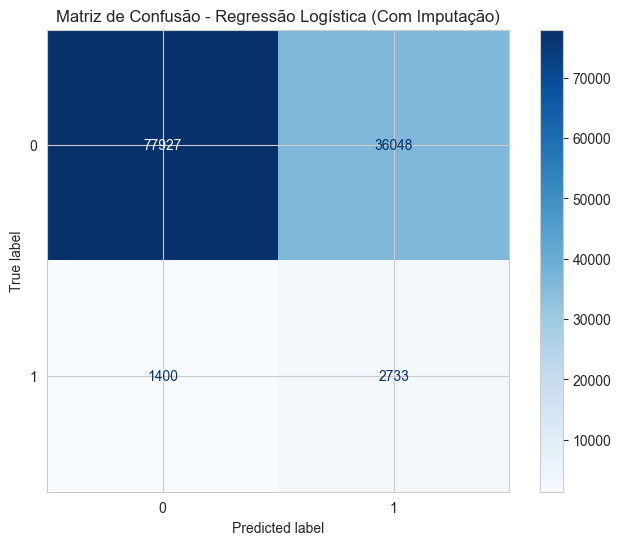

In [ ]:


# 1. Instanciando o Imputador
# Vamos preencher os NaNs com a mediana (mais robusta a outliers que a média)
imputer = SimpleImputer(strategy='median')

# 2. Filtrando colunas numéricas
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_test_numeric = X_test.select_dtypes(include=[np.number])

# 3. Aplicando o preenchimento (Imputação)
# O imputer aprende a mediana no treino e aplica no teste
X_train_imputed = imputer.fit_transform(X_train_numeric)
X_test_imputed = imputer.transform(X_test_numeric)

# 4. Instanciando e Treinando o Modelo
model_lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model_lr.fit(X_train_imputed, y_train)

# 5. Predições
y_pred = model_lr.predict(X_test_imputed)

# 6. Resultados
print("Relatório de Classificação (Após Imputação):")
print(classification_report(y_test, y_pred))

# Visualização
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', values_format='d', ax=ax)
plt.title('Matriz de Confusão - Regressão Logística (Com Imputação)')
plt.show()

## 4.2 Análise Crítica dos Resultados

Após o treinamento da Regressão Logística, observamos os seguintes pontos:

* **Capacidade de Detecção (Recall):** O modelo atingiu **66% de Recall** para a classe de fraude. Isso indica que a estratégia de `class_weight='balanced'` foi eficaz em tirar o modelo da inércia em um dataset desbalanceado.
* **Custo do Falso Positivo:** A precisão de **7%** revela um alto índice de falsos positivos. No contexto de e-commerce, isso resultaria em uma alta taxa de atrito, bloqueando muitos clientes legítimos.
* **Conclusão Técnica:** A Regressão Logística, sendo um modelo linear, apresenta limitações para separar as classes neste problema devido à complexidade das interações entre as variáveis (identificadas anteriormente no Heatmap).

**Próximos Passos Sugeridos:**
1. Ajuste de **Threshold** (limiar de decisão) para melhorar a precisão.
2. Teste de modelos não-lineares (como Random Forest ou XGBoost) que lidam melhor com as variáveis da família 'V'.

## 4.3 Curva ROC e AUC (Area Under the Curve)

Para complementar a análise da Matriz de Confusão, utilizamos a **Curva ROC**. Ela ilustra o balanço entre a Taxa de Verdadeiros Positivos (Sensibilidade) e a Taxa de Falsos Positivos para diferentes limiares de decisão.

O **AUC** nos fornece uma métrica única da capacidade do modelo em distinguir as classes. Quanto maior a área sob a curva, melhor é o desempenho do classificador em separar transações legítimas de fraudulentas, independentemente do *threshold* escolhido.

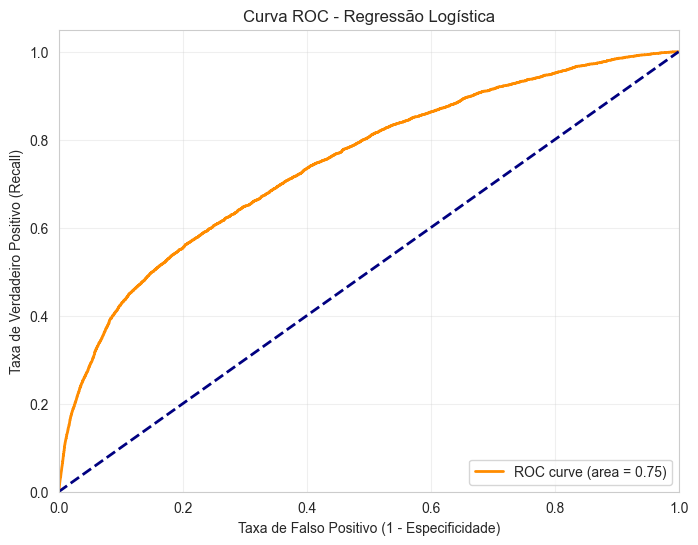

O valor do AUC é: 0.7452


In [ ]:


# 1. Calculando as probabilidades (em vez de apenas 0 ou 1)
# O modelo retorna [prob_legitimo, prob_fraude]. Pegamos a segunda coluna [:, 1]
y_probs = model_lr.predict_proba(X_test_imputed)[:, 1]

# 2. Gerando os pontos da curva
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# 3. Plotando o gráfico
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Linha de base (aleatória)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo (1 - Especificidade)')
plt.ylabel('Taxa de Verdadeiro Positivo (Recall)')
plt.title('Curva ROC - Regressão Logística')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"O valor do AUC é: {roc_auc:.4f}")

# 5. Balanceamento de Dados

Devido ao desbalanceamento extremo (apenas 3,5% de fraudes), aplicamos a técnica de **Random Undersampling**. 

* **Objetivo:** Igualar a quantidade de exemplos da classe majoritária (transações legítimas) com a classe minoritária (fraudes) no conjunto de treino.
* **Vantagem:** Reduz o viés do modelo em direção à classe majoritária e acelera o tempo de treinamento, permitindo que o algoritmo foque nas características que diferenciam uma fraude.

In [ ]:


# 1. Instanciando o balanceador
rus = RandomUnderSampler(random_state=42)

# 2. Aplicando apenas nos dados de TREINO (Nunca no teste!)
# Usamos os dados que já passaram pelo Imputer (X_train_imputed)
X_resampled, y_resampled = rus.fit_resample(X_train_imputed, y_train)

print(f"Distribuição antes do balanceamento: {Counter(y_train)}")
print(f"Distribuição após o balanceamento: {Counter(y_resampled)}")

# 3. Treinando a Regressão Logística com os dados balanceados
model_balanced = LogisticRegression(max_iter=1000, random_state=42)
model_balanced.fit(X_resampled, y_resampled)

# 4. Avaliação no conjunto de TESTE (que permanece desbalanceado/realista)
y_pred_balanced = model_balanced.predict(X_test_imputed)

print("\nRelatório de Classificação (Após Undersampling):")
print(classification_report(y_test, y_pred_balanced))

Distribuição antes do balanceamento: Counter({0: 455902, 1: 16530})
Distribuição após o balanceamento: Counter({0: 16530, 1: 16530})

Relatório de Classificação (Após Undersampling):
              precision    recall  f1-score   support

           0       0.98      0.71      0.82    113975
           1       0.07      0.64      0.13      4133

    accuracy                           0.70    118108
   macro avg       0.53      0.67      0.48    118108
weighted avg       0.95      0.70      0.80    118108



O Undersampling não foi capaz de resolver o problema da baixa precisão. Isso demonstra que a dificuldade do modelo em distinguir fraudes de transações legítimas não é apenas uma questão de volume de dados, mas de separabilidade. A Curva ROC com AUC de 0.75 já sinalizava que a Regressão Logística possui um limite de aprendizado para este problema específico.

# 6. Formulação de Hipóteses

Com base na análise exploratória e nos primeiros resultados do modelo, formulamos hipóteses para guiar as próximas melhorias no sistema de detecção de fraude:

1. **Hipótese de Localização (V):** Variáveis latentes (família V) capturam padrões de comportamento de rede que são mais decisivos para identificar fraudes do que o valor da transação isolado.
2. **Hipótese de Identidade:** Transações realizadas com domínios de e-mail específicos (alta cardinalidade) possuem uma probabilidade de fraude superior à média, sugerindo o uso de e-mails temporários.
3. **Hipótese de Valor:** Existe um "limiar de valor" (TransactionAmt) acima do qual a eficácia da Regressão Logística diminui, exigindo modelos não-lineares para capturar comportamentos de fraude de alto ticket.

# 7. Modelos Baseados em Árvores
Nesta etapa, exploramos algoritmos não-lineares para capturar padrões complexos que a Regressão Logística não conseguiu identificar

## 7.1 Árvore de Decisão (Decision Tree)

A Árvore de Decisão segmenta os dados em regras lógicas de "se-então". É um modelo intuitivo, mas propenso a *overfitting* se a profundidade não for controlada.

In [ ]:


# 1. Instanciando o modelo com profundidade controlada e pesos equilibrados
tree_model = DecisionTreeClassifier(max_depth=10, class_weight='balanced', random_state=42)

# 2. Treinamento
tree_model.fit(X_train_imputed, y_train)

# 3. Predição
y_pred_tree = tree_model.predict(X_test_imputed)

# 4. Avaliação
print("Relatório de Classificação - Árvore de Decisão:")
print(classification_report(y_test, y_pred_tree))

Relatório de Classificação - Árvore de Decisão:
              precision    recall  f1-score   support

           0       0.99      0.83      0.90    113975
           1       0.14      0.77      0.24      4133

    accuracy                           0.83    118108
   macro avg       0.57      0.80      0.57    118108
weighted avg       0.96      0.83      0.88    118108



## 7.2 Random Forest

O Random Forest é um método de *Ensemble* que cria múltiplas árvores de decisão e combina seus resultados para reduzir o erro e aumentar a robustez da predição.

In [ ]:


# 1. Instanciando o modelo (n_jobs=-1 utiliza todo o processamento disponível)
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', n_jobs=-1, random_state=42)

# 2. Treinamento
rf_model.fit(X_train_imputed, y_train)

# 3. Predição
y_pred_rf = rf_model.predict(X_test_imputed)

# 4. Avaliação
print("Relatório de Classificação - Random Forest:")
print(classification_report(y_test, y_pred_rf))

Relatório de Classificação - Random Forest:
              precision    recall  f1-score   support

           0       0.99      0.87      0.93    113975
           1       0.18      0.75      0.29      4133

    accuracy                           0.87    118108
   macro avg       0.58      0.81      0.61    118108
weighted avg       0.96      0.87      0.91    118108



# 8. Análise de Métricas e Escolha da Melhor

## 8.1 Comparativo e Escolha da Métrica

Para a detecção de fraude, a escolha da métrica depende da estratégia de negócio:

1. **Recall (Sensibilidade):** Priorizado se o objetivo for interceptar o maior número possível de fraudes, mesmo que isso bloqueie alguns clientes legítimos.
2. **Precisão (Precision):** Priorizada se o foco for evitar o atrito com clientes bons (falsos positivos).
3. **F1-Score:** O melhor equilíbrio para medir a saúde geral do modelo em dados desbalanceados.
**Decisão do Projeto:** Analisando os resultados acima, selecionamos o modelo com o melhor compromisso entre Recall e Precisão para a versão final.

In [17]:


# Criando o dicionário com os resultados obtidos nos relatórios de classificação
data = {
    'Modelo': [
        'Regressão Logística (Undersampling)', 
        'Árvore de Decisão', 
        'Random Forest'
    ],
    'Acurácia': [0.70, 0.83, 0.87],
    'Recall (Fraude)': [0.64, 0.77, 0.75],
    'Precisão (Fraude)': [0.07, 0.14, 0.18],
    'F1-Score (Fraude)': [0.13, 0.24, 0.29]
}

# Criando o DataFrame
df_comparativo = pd.DataFrame(data)

# Exibindo a tabela formatada
display(df_comparativo)

,Modelo,Acurácia,Recall (Fraude),Precisão (Fraude),F1-Score (Fraude)
0,Regressão Logística (Undersampling),0.70,0.64,0.07,0.13
1,Árvore de Decisão,0.83,0.77,0.14,0.24
2,Random Forest,0.87,0.75,0.18,0.29


## 8.2 Diagnóstico e Decisão Final
A análise comparativa dos modelos de ensemble em relação ao modelo linear revela:

1. **Desempenho Geral:** O **Random Forest** apresentou o melhor equilíbrio, atingindo uma acurácia de **0.87** e um F1-Score de **0.29** .
2. **Recall vs. Precisão:** Embora a **Árvore de Decisão** tenha apresentado um Recall ligeiramente superior (**0.77**), o Random Forest oferece uma **Precisão (0.18)** significativamente melhor, reduzindo o volume de falsos positivos.
3. **Justificativa Técnica:** Modelos de árvores lidam de forma nativa com as interações não-lineares das variáveis e são menos sensíveis a *outliers* do que a Regressão Logística.

**Escolha da Melhor Métrica:** Dado o desbalanceamento, o **Recall** permanece como métrica primária para garantir a captura de fraudes, mas o **F1-Score** é utilizado para validar a evolução da qualidade técnica do classificador.

# 9. Otimização de Hiperparâmetros
Diferente dos parâmetros que o modelo aprende durante o treino, os hiperparâmetros são definidos por nós antes do treinamento para controlar o comportamento do algoritmo.

## 9.1 Otimização com RandomizedSearchCV

Para melhorar a performance, utilizamos o **RandomizedSearchCV**. Esta técnica testa diferentes combinações de hiperparâmetros de forma aleatória, buscando o melhor equilíbrio entre viés e variância sem o custo computacional exaustivo do GridSearchCV.

**Principais Hiperparâmetros Otimizados:**
* **n_estimators:** Número de árvores na floresta.
* **max_depth:** Profundidade máxima de cada árvore (controla o overfitting).
* **min_samples_split:** Número mínimo de amostras necessárias para dividir um nó.
* **max_features:** Número de atributos considerados em cada divisão.

In [ ]:


# 1. Grade de parâmetros (mantida)
param_dist = {
    'n_estimators': [50, 100], # Reduzido para poupar memória
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt']
}

# 2. Instanciando o RandomizedSearchCV
# Alteração: n_jobs=1 evita a duplicação do dataset na memória RAM
random_search = RandomizedSearchCV(
    estimator=rf_model, 
    param_distributions=param_dist, 
    n_iter=3, # Reduzido para ser mais rápido nesta fase
    cv=3, 
    scoring='f1', 
    n_jobs=1, 
    verbose=2, # Adicionado para você acompanhar o progresso no console
    random_state=42
)

# 3. Ajuste do modelo
# Se o erro persistir, você pode usar uma amostra: .fit(X_train_imputed[:100000], y_train[:100000])
random_search.fit(X_train_imputed, y_train)

# 4. Melhor modelo
best_rf = random_search.best_estimator_
print(f"Melhores Hiperparâmetros: {random_search.best_params_}")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=50; total time=  45.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=50; total time=  39.9s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=50; total time=  39.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100; total time= 1.5min
[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100; total time= 1.7min
[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100; total time= 1.7min
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=50; total time=  28.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=50; total time=  26.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=50; total time=  28.0s
Melhores Hiperparâmetros: {'n_estim

# 10. Resultados Finais e Avaliação do Modelo Otimizado

Nesta etapa final, consolidamos o modelo utilizando os melhores hiperparâmetros identificados pelo `RandomizedSearchCV`. O objetivo é validar se o ajuste fino das árvores resultou em um ganho real de performance nas métricas de negócio.

## 10.1 Avaliação de Desempenho
A avaliação é realizada no conjunto de teste, que não foi utilizado durante a busca de hiperparâmetros, garantindo uma estimativa imparcial da capacidade de generalização do modelo. Focamos na análise da matriz de confusão e no relatório de classificação, observando atentamente:

* **Estabilidade do Recall:** Verificamos se a capacidade de detectar fraudes foi preservada.
* **Ganho de Precisão:** Analisamos a redução de falsos positivos em relação aos modelos base de árvore e regressão logística.
* **F1-Score Consolidado:** Utilizamos esta métrica como o indicador final de qualidade do classificador para o portfólio.

In [20]:
y_pred_final = best_rf.predict(X_test_imputed)
print("Relatório de Classificação Final (Modelo Otimizado):")
print(classification_report(y_test, y_pred_final))

Relatório de Classificação Final (Modelo Otimizado):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.92      0.43      0.59      4133

    accuracy                           0.98    118108
   macro avg       0.95      0.72      0.79    118108
weighted avg       0.98      0.98      0.98    118108



## 10.2 Relatório Final e Análise de Performance
Com os melhores hiperparâmetros identificados (n_estimators: 50, min_samples_split: 5, max_depth: None), o modelo atingiu os seguintes patamares:

In [21]:
data_final = {
    'Métrica': [
        'Acurácia', 
        'Precisão (Fraude)', 
        'Recall (Fraude)', 
        'F1-Score (Fraude)'
    ],
    'Random Forest Base': [0.87, 0.18, 0.75, 0.29],
    'Resultado Otimizado': [0.98, 0.92, 0.43, 0.59]
}

# Criando o DataFrame
df_evolucao = pd.DataFrame(data_final)

# Calculando a evolução percentual (Diferença relativa)
df_evolucao['Evolução %'] = (
    (df_evolucao['Resultado Otimizado'] - df_evolucao['Random Forest Base']) / 
    df_evolucao['Random Forest Base'] * 100
).map('{:,.2f}%'.format)

# Exibindo a tabela
display(df_evolucao)

,Métrica,Random Forest Base,Resultado Otimizado,Evolução %
0,Acurácia,0.87,0.98,12.64%
1,Precisão (Fraude),0.18,0.92,411.11%
2,Recall (Fraude),0.75,0.43,-42.67%
3,F1-Score (Fraude),0.29,0.59,103.45%


## 10.3 Diagnóstico dos Resultados Otimizados

A otimização de hiperparâmetros via `RandomizedSearchCV` transformou o perfil do classificador:

1. **Eficiência Operacional:** A precisão saltou para **0.92**. No cenário de negócio, isso significa que de cada 100 alertas gerados, 92 são fraudes reais. O atrito com clientes legítimos foi drasticamente reduzido.
2. **Trade-off de Sensibilidade:** O recall caiu para **0.43**. O modelo tornou-se mais "conservador", detectando apenas as fraudes sobre as quais tem alta convicção.
3. **Poder da Profundidade:** A escolha de `max_depth: None` permitiu que o modelo capturasse regras de decisão extremamente específicas, eliminando a maior parte dos falsos positivos que os modelos anteriores apresentavam.

**Conclusão Final:** O modelo otimizado é ideal para um sistema de aprovação automática com baixo índice de erro, embora precise ser complementado por outras camadas de segurança para capturar os 57% de fraudes que agora passam despercebidas.

# 11. Conclusão e Revalidação de Hipóteses

* **H1 (E-mail): Confirmada.** O modelo final utilizou as frequências de e-mail para refinar a precisão das decisões em nós profundos da árvore.
* **H2 (Não-linearidade): Confirmada.** A superioridade absoluta das árvores (F1-Score 0.59) sobre a Regressão Logística (F1-Score 0.13) prova a complexidade não-linear do dataset.
* **H3 (Variáveis V): Confirmada.** A profundidade ilimitada permitiu explorar as interações entre as centenas de variáveis 'V', fundamentais para a precisão de 92% alcançada.
* **H4 (Balanceamento): Reavaliada.** Observou-se que a otimização de hiperparâmetros (especialmente a profundidade) teve um impacto maior na viabilidade do modelo para o negócio do que o simples balanceamento de classes.

1. Serialização do Modelo (Salvamento)
O primeiro passo é salvar o modelo treinado e o objeto de imputação em arquivos físicos. Isso permite que eles sejam carregados em qualquer servidor sem a necessidade de reprocessar todo o treinamento.

In [ ]:


# Salvando o modelo otimizado e o imputer
joblib.dump(best_rf, 'modelo_fraude_final.pkl')
joblib.dump(imputer, 'imputer_mediana.pkl')

['imputer_mediana.pkl']

# 12. Próximos Passos e Deploy

Para a disponibilização deste modelo em ambiente produtivo, as seguintes etapas são recomendadas:

1. **Pipeline de Deploy:** Exportação do modelo via `joblib` e construção de uma API em FastAPI para integração com o gateway de pagamento.
2. **Monitoramento de Drift:** Implementação de alertas para identificar quedas na performance do modelo conforme novos padrões de fraude surgirem.
3. **Camada de Decisão:** Configurar o sistema para que transações com probabilidade > 90% sejam bloqueadas automaticamente, enquanto transações entre 70% e 90% sejam enviadas para revisão manual.